In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)

CSV_PATH = "./data/data_nervioso.csv"


In [16]:
df = pd.read_csv(CSV_PATH, thousands=".", decimal=",") #

bad_values = ["Sense especificar", "Altres", "ALTRES", "SENSE ESPECIFICAR", "VARIOS"]

df = df.dropna()                     # remove NaNs
df = df[~df.isin(bad_values).any(axis=1)]

translations = {
    'ANALGESICOS': "Analgesics",
    'ANTIEPILEPTICOS': "Antiepileptics",
    'PSICOLEPTICOS': "Psycholeptics",        
    'ANTIPARKINSONIANOS': "Antiparkinsonians",
    'PSICOANALEPTICOS': "Psychoanaleptics",  
    'ANESTESICOS': "Anesthetics",
    'OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO': "Other nervous-system drugs"
}

translations2 = {
    'ANSIOLITICOS': "Anxiolytics",
    'ANTIPSICOTICOS': "Antipsychotics",
    'HIPNOTICOS Y SEDANTES': "Hypnotics and Sedatives",
    'ANTIDEPRESIVOS': "Antidepressants",
    'PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS': "Agents Used for ADHD",
    'PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA TDAH Y NOOTROPICOS' : "Agents Used for ADHD",
    'PSICOESTIMULANTES, AGENTES UTILIZADOS PARA EL TDAH Y NOOTROPICOS' : "Agents Used for ADHD",
    'FARMACOS ANTI-DEMENCIA': "Anti-dementia Drugs",
    'PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION': "Psycholeptics and Psychoanaleptics in Combination"
}

df["grup ATC nivell 2"] = df["grup ATC nivell 2"].replace(translations)
df["grup ATC nivell 3"] = df["grup ATC nivell 3"].replace(translations2)
df = df[df["grup ATC nivell 3"] != "Psycholeptics and Psychoanaleptics in Combination"]
# df = df[df["grup ATC nivell 3"] != 'PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS']


In [17]:
df["nombre de receptes"].max()

87211

In [18]:
def age_sort_key(age_str):
    # Handle special categories
    if age_str == "Altres":
        return 999
    if age_str == "Sense especificar":
        return 1000
    if age_str == "85+":   # our replaced "Més de 84 anys"
        return 85

    # Extract starting number (e.g., "20-24" → 20)
    m = re.match(r"(\d+)", age_str)
    if m:
        return int(m.group(1))
    return None


df["age_key"] = df["grup d'edat"].apply(age_sort_key)
age_counts = df.groupby(["grup d'edat", "age_key"])["nombre de receptes"].sum()
age_counts = age_counts.reset_index().sort_values("age_key")
ordered_ages = age_counts["grup d'edat"].tolist()

df["grup d'edat"] = pd.Categorical(
    df["grup d'edat"],
    categories=ordered_ages,
    ordered=True
)

In [19]:
df_nerv = df
# df_nerv["grup ATC nivell 3"].unique()

selected_lvl2 = ['Psycholeptics', 'Psychoanaleptics']
df_filtered = df_nerv[df_nerv["grup ATC nivell 2"].isin(selected_lvl2)]

C:\Users\gerar\AppData\Local\Temp\ipykernel_2480\2872321027.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["grup d'edat", "grup ATC nivell 3"])["nombre de receptes"]


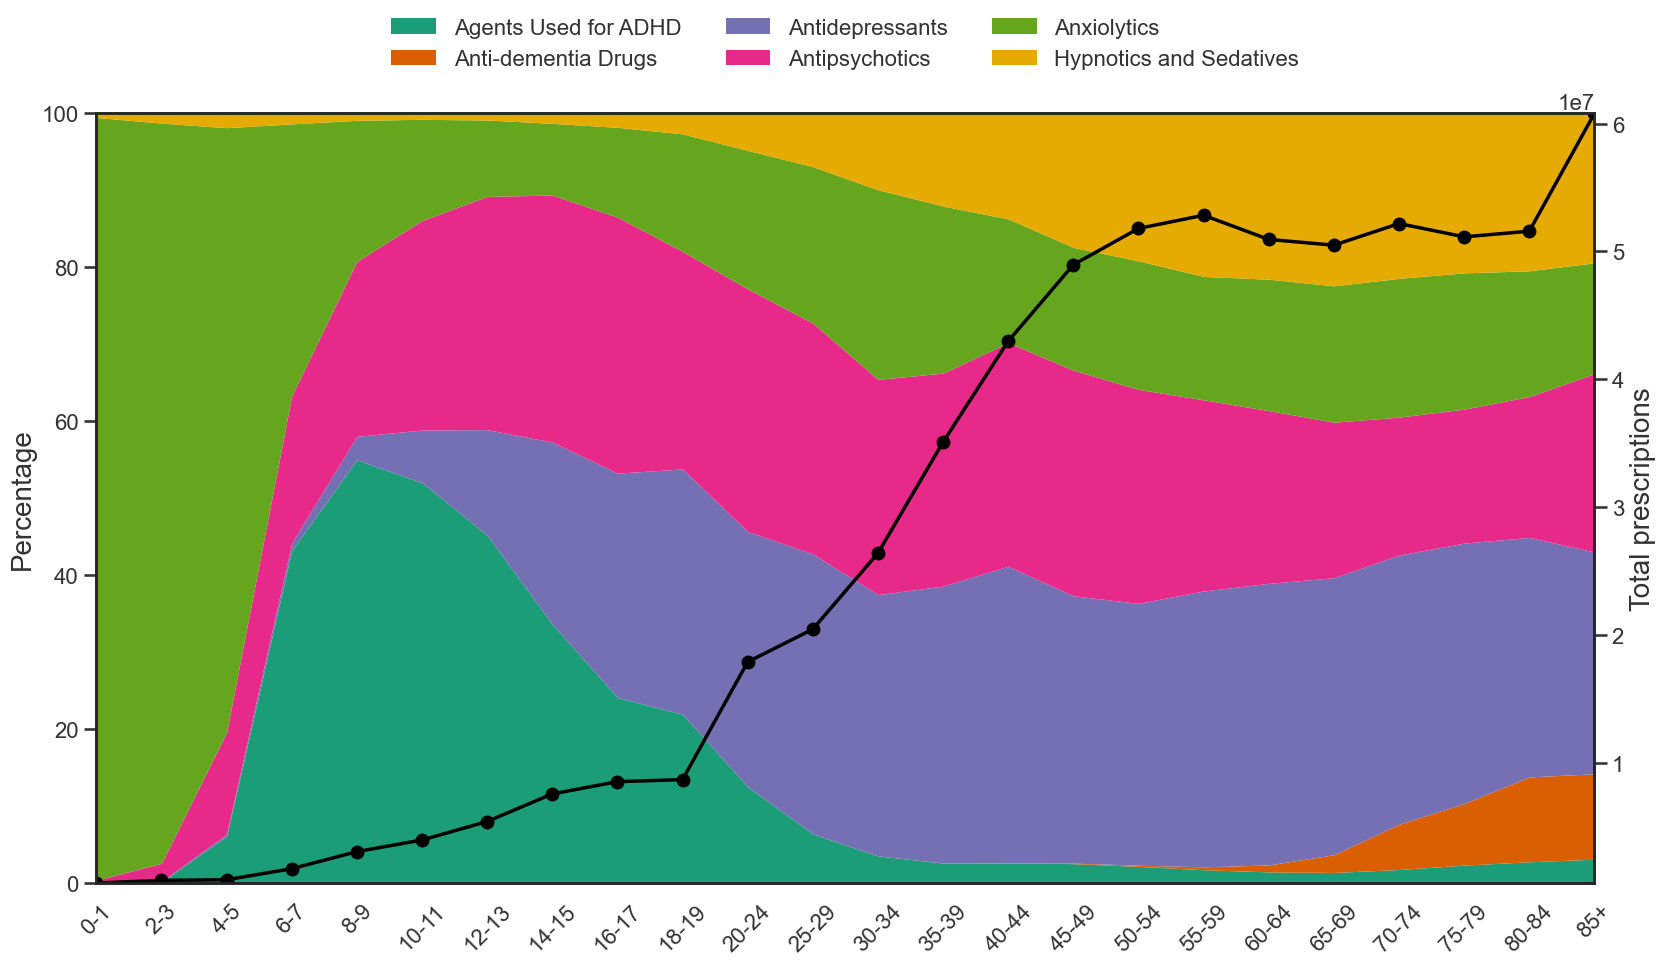

In [20]:
lvl3_by_age = (
    df_filtered
    .groupby(["grup d'edat", "grup ATC nivell 3"])["nombre de receptes"]
    .sum()
    .unstack(fill_value=0)
)

# Ensure age ordering (same as your original code)
lvl3_by_age = lvl3_by_age.loc[df["grup d'edat"].cat.categories]

# Normalize to percentage per age group
lvl3_pct = lvl3_by_age.div(lvl3_by_age.sum(axis=1), axis=0) * 100

# Use a nice distinct palette
colors = sns.color_palette("tab20", n_colors=len(lvl3_pct.columns))

plt.rcParams.update({
    "font.size": 18,        # base font size
    "axes.titlesize": 22,   # title font
    "axes.labelsize": 20,   # axis labels
    "xtick.labelsize": 16,  # x-axis tick labels
    "ytick.labelsize": 16,  # y-axis tick labels
    "legend.fontsize": 16   # legend text
})

# assume lvl3_pct and totals are defined as before
totals = lvl3_by_age.sum(axis=1)
x = np.arange(len(lvl3_pct.index))
y_stack = lvl3_pct.values.T

fig, ax = plt.subplots(figsize=(17, 10))

# stacked percentages (base colors)
base_colors = sns.color_palette("Dark2", n_colors=len(lvl3_pct.columns))
cumulative = np.zeros(len(x))
for i, (col, y) in enumerate(zip(lvl3_pct.columns, y_stack)):
    y2 = cumulative + y
    ax.fill_between(x, cumulative, y2, color=base_colors[i], label=col, linewidth=0)
    cumulative = y2

ax.set_xticks(x)
ax.set_xticklabels(lvl3_pct.index, rotation=45)
ax.set_ylabel("Percentage")
ax.margins(x=0, y = 0)
# ax.set_title("ATC Level 3 — Share of Prescriptions by Age Group (Female)")

# secondary axis for totals
ax2 = ax.twinx()
# # plot totals as a thick line (or use ax2.fill_between for an area)
ax2.plot(x, totals.values, color="black", linewidth=2.5, marker="o", label="Total prescriptions")
ax2.set_ylabel("Total prescriptions")
ax2.margins(x=0, y = 0)

# optionally make the totals easier to compare by adding markers or smoothing

# legends: one for stacks, one for totals
handles, labels = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    frameon=False
)

# ax2.legend(
#     loc="upper left",
#     bbox_to_anchor=(0.5, 1.08),
#     frameon=False
# )

plt.tight_layout()
plt.savefig("../plots/age_evolution_mental.pdf")
plt.show()


In [24]:
def gender_pct(df, atc_col):
    """
    Returns: a dict { 'Male': pivot, 'Female': pivot }
    Each pivot is: index = age, columns = ATC categories, values = % share.
    """
    results = {}
    for sex in ["Home", "Dona"]:      # adapt to your labels if needed
        subset = df[df["sexe"] == sex]

        table = (
            subset
            .groupby(["grup d'edat", atc_col])["nombre de receptes"]
            .sum()
            .unstack(fill_value=0)
            .loc[df["grup d'edat"].cat.categories]
        )

        pct = table.div(table.sum(axis=1), axis=0) * 100
        results[sex] = pct

    return results

C:\Users\gerar\AppData\Local\Temp\ipykernel_2480\2539955243.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["grup d'edat", atc_col])["nombre de receptes"]
C:\Users\gerar\AppData\Local\Temp\ipykernel_2480\2539955243.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["grup d'edat", atc_col])["nombre de receptes"]


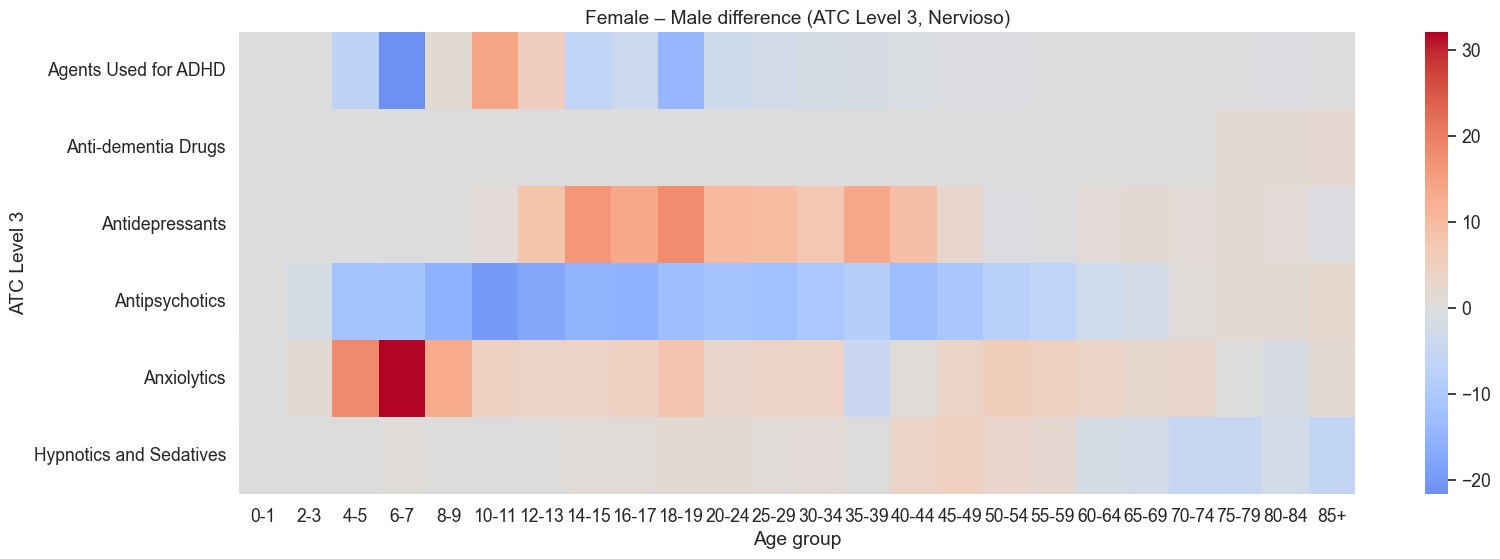

In [25]:
pct_gender2 = gender_pct(subset, "grup ATC nivell 3")
male_pct2   = pct_gender2["Home"]
female_pct2 = pct_gender2["Dona"]
delta2 = female_pct2 - male_pct2

plt.figure(figsize=(18,6))
sns.heatmap(delta2.T, cmap="coolwarm", center=0)
plt.title("Female – Male difference (ATC Level 3, Nervioso)")
plt.xlabel("Age group")
plt.ylabel("ATC Level 3")
plt.show()

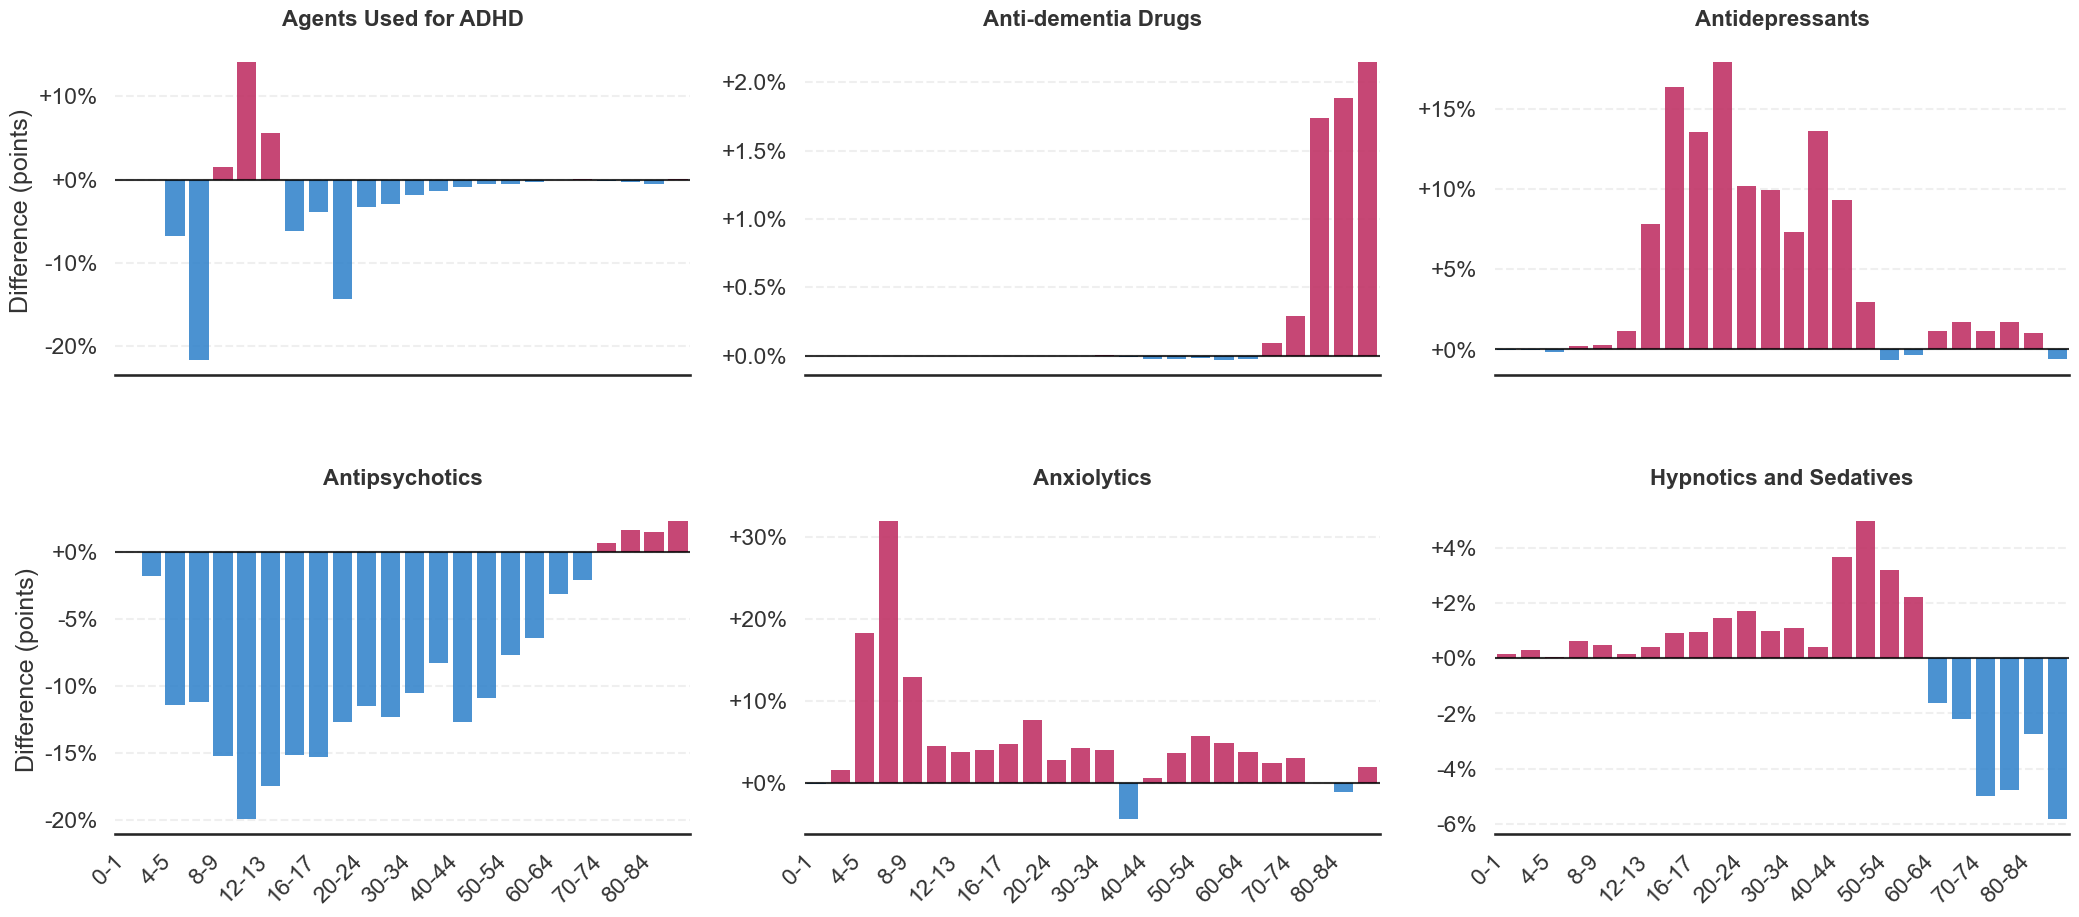

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- 1. DATA PREPARATION ---
# (Assumes df_nerv is loaded in your environment)
selected_lvl2 = ['Psycholeptics', 'Psychoanaleptics']
subset = df_nerv[df_nerv["grup ATC nivell 2"].isin(selected_lvl2)].copy()
subset = subset[subset["sexe"].isin(["Home", "Dona"])]

# Group & Calculate Shares
grouped = subset.groupby(["grup d'edat", "sexe", "grup ATC nivell 3"], observed=False)["nombre de receptes"].sum()
totals = grouped.groupby(["grup d'edat", "sexe"], observed=False).transform("sum")
pcts = (grouped / totals * 100).reset_index(name="Percentage")

# Pivot to get Difference
pivot = pcts.pivot_table(
    index=["grup ATC nivell 3", "grup d'edat"], 
    columns="sexe", 
    values="Percentage", 
    fill_value=0
).reset_index()

pivot["Difference"] = pivot["Dona"] - pivot["Home"]
pivot["Bias"] = pivot["Difference"].apply(lambda x: "Female Bias" if x > 0 else "Male Bias")

# --- 2. VISUALIZATION STYLE ---
sns.set_theme(style="white", context="talk") 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#333333'
plt.rcParams['axes.labelcolor'] = '#333333'
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

custom_palette = {"Female Bias": "#D81B60", "Male Bias": "#1E88E5"}

# --- 3. PLOTTING ---
g = sns.FacetGrid(
    pivot, 
    col="grup ATC nivell 3", 
    col_wrap=3, 
    height=5, 
    aspect=1.4, 
    sharey=False, 
    sharex=True 
)

def plot_diverging_bars(x, y, hue, **kwargs):
    # Extract data safely
    data = kwargs.pop("data") 
    ax = plt.gca()
    
    sns.barplot(
        data=data, 
        x=x, 
        y=y, 
        hue=hue, 
        palette=custom_palette, 
        dodge=False, 
        ax=ax, 
        edgecolor="none", 
        alpha=0.9
    )
    
    ax.axhline(0, color='black', linewidth=1.5, alpha=0.8)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

g.map_dataframe(plot_diverging_bars, x="grup d'edat", y="Difference", hue="Bias")


# --- 4. POLISHING THE DETAILS ---
i = 0
s = [0,1,0,0,0,0]
for ax in g.axes.flat:
    # 1. Clean Titles
    original_title = ax.get_title()
    if "=" in original_title:
        drug_name = original_title.split("=")[-1].strip()
        ax.set_title(drug_name, fontweight='bold', fontsize=16, pad=15)
    
    # 2. Format Y-Axis (+/- signs)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter(f'%+.{s[i]}f%%'))
    
    # 3.Show only every 2nd label on X-axis to reduce clutter
    # This works because categorical plots use 0, 1, 2... as x-coordinates
    ax.xaxis.set_major_locator(mtick.MultipleLocator(2))

    # 4. Remove box outline
    sns.despine(ax=ax, left=True, bottom=False)
    
    # 5. Rotate X-labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    i = i+1

# --- 5. FINAL LAYOUT ---
g.set_axis_labels("", "Difference (points)")
plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.2)
# g._legend.remove() # Uncomment if you want to remove the side legend

plt.savefig("../plots/diverging_bars_sex_diff.pdf", bbox_inches='tight')
plt.show()